<a href="https://colab.research.google.com/github/beyzaturku/2209/blob/main/low_alt_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   .json uzantılı dosyalar yolo modeli için uygun hale (txt) getiriliyor

In [ ]:
import os
import json
from glob import glob

json_folder = "/content/drive/MyDrive/2209/low_alt/low_alt_annotations"

output_folder = "/content/drive/MyDrive/2209/low_alt/yolo_labels"
os.makedirs(output_folder, exist_ok=True)

class_list = ["car", "vehicle", "truck", "bus"]

json_files = glob(os.path.join(json_folder, "*.json"))

for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)

    img_width = data["size"]["width"]
    img_height = data["size"]["height"]

    base_name = os.path.splitext(os.path.basename(json_file))[0]

    txt_file_path = os.path.join(output_folder, base_name + ".txt")

    with open(txt_file_path, "w") as out_file:
        for obj in data.get("objects", []):
            class_title = obj.get("classTitle", "").lower()
            if class_title not in class_list:
                print(f"Sınıf '{class_title}' JSON: {json_file} dosyasında bulunamadı.")
                continue

            class_id = class_list.index(class_title)

            exterior_points = obj.get("points", {}).get("exterior", [])
            if len(exterior_points) != 2:
                print(f"Uyarı: Beklenmeyen nokta sayısı {len(exterior_points)} JSON: {json_file}")
                continue

            x1, y1 = exterior_points[0]
            x2, y2 = exterior_points[1]

            x_center = (x1 + x2) / 2.0
            y_center = (y1 + y2) / 2.0
            bbox_width = x2 - x1
            bbox_height = y2 - y1

            x_center_norm = x_center / img_width
            y_center_norm = y_center / img_height
            w_norm = bbox_width / img_width
            h_norm = bbox_height / img_height

            line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}\n"
            out_file.write(line)

print("Tüm JSON dosyaları YOLO formatına dönüştürüldü!")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000399.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000400.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000401.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000402.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000403.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000404.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000405.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000406.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000407.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000408.jpg.txt oluşturuldu.
/content/drive/MyDrive/2209/low_alt/yolo_labels/M1304_img000409.jpg.txt oluşturuldu.
/content/drive/MyD



*   images dosyası hazır
*   annotation dosyası hazır
*   labels dosyası hazır





*   Overfitting ihtimalini azaltmak için veri seti train ve val olarak ikiye ayrılır.




In [ ]:
import os
import shutil
import random

image_dir = "/content/drive/MyDrive/2209/low_alt/low_alt_images"
label_dir = "/content/drive/MyDrive/2209/low_alt/yolo_labels"

train_img_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/train"
val_img_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/val"
train_label_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/train"
val_label_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/val"

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")]

random.shuffle(image_files)
split_index = int(len(image_files) * 0.8)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

for file in train_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(train_img_dir, file))
    label_file = file.replace(".jpg", ".txt").replace(".png", ".txt")
    if os.path.exists(os.path.join(label_dir, label_file)):
        shutil.move(os.path.join(label_dir, label_file), os.path.join(train_label_dir, label_file))

for file in val_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(val_img_dir, file))
    label_file = file.replace(".jpg", ".txt").replace(".png", ".txt")
    if os.path.exists(os.path.join(label_dir, label_file)):
        shutil.move(os.path.join(label_dir, label_file), os.path.join(val_label_dir, label_file))

print("✅ Veri seti başarıyla train ve val olarak ayrıldı!")

✅ Veri seti başarıyla train ve val olarak ayrıldı!


*  Görseller train ve val olarak ayrıldı. Şimdi labellar train ve val olarak ayrılmalı

In [ ]:
import os
import shutil

image_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/train"
image_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/val"

label_source_dir = "/content/drive/MyDrive/2209/low_alt/yolo_labels"
label_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/train"
label_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/val"

os.makedirs(label_train_dir, exist_ok=True)

train_images = os.listdir(image_train_dir)

copied_files = []

for img_file in train_images:
    img_name, _ = os.path.splitext(img_file)
    label_file = img_name + ".jpg.txt"

    src_path = os.path.join(label_source_dir, label_file)
    dest_path = os.path.join(label_train_dir, img_name + ".txt")

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
        copied_files.append(img_name + ".txt")

if copied_files:
    print("✅ Başarıyla kopyalandı.")

else:
    print("⚠️ Hiçbir dosya kopyalanmadı. Dosya adlarını kontrol et!")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
M1005_img000514.txt
M1005_img000457.txt
M1005_img000456.txt
M1005_img000455.txt
M1005_img000478.txt
M1005_img000477.txt
M1005_img000479.txt
M1005_img000476.txt
M1005_img000438.txt
M1005_img000426.txt
M1005_img000425.txt
M1005_img000427.txt
M1005_img000472.txt
M1005_img000471.txt
M1005_img000483.txt
M1005_img000484.txt
M1005_img000482.txt
M1006_img000004.txt
M1005_img000495.txt
M1005_img000488.txt
M1005_img000461.txt
M1005_img000460.txt
M1006_img000087.txt
M1005_img000485.txt
M1005_img000487.txt
M1005_img000486.txt
M1005_img000367.txt
M1005_img000366.txt
M1005_img000405.txt
M1005_img000400.txt
M1005_img000489.txt
M1005_img000443.txt
M1005_img000450.txt
M1005_img000319.txt
M1005_img000320.txt
M1005_img000322.txt
M1005_img000321.txt
M0703_img000461.txt
M0703_img000463.txt
M0703_img000464.txt
M0703_img000462.txt
M1006_img000007.txt
M1006_img000008.txt
M1006_img000006.txt
M1005_img000496.txt
M1005_img000491.txt
M1005_img000492.txt
M1005_img0004

*   Etiket ve görsel kontrolü:


In [ ]:
import os

image_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/train"
label_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/train"

image_files = {os.path.splitext(f)[0] for f in os.listdir(image_train_dir)}
label_files = {os.path.splitext(f)[0] for f in os.listdir(label_train_dir)}

common_files = image_files.intersection(label_files)
missing_labels = image_files - label_files
missing_images = label_files - image_files

print(f"📂 Toplam {len(image_files)} görüntü dosyası, {len(label_files)} etiket dosyası var.")
print(f"✅ Eşleşen dosya sayısı: {len(common_files)}")

if missing_labels:
    print(f"⚠️ {len(missing_labels)} görüntü dosyasının etiketi eksik!")
    print("\nEksik etiketler:")
    for file in list(missing_labels)[:10]:
        print(file + ".txt")

if missing_images:
    print(f"⚠️ {len(missing_images)} etiket dosyasının görüntüsü eksik!")
    print("\nEksik görüntüler:")
    for file in list(missing_images)[:10]:
        print(file + ".jpg")


📂 Toplam 6125 görüntü dosyası, 6125 etiket dosyası var.
✅ Eşleşen dosya sayısı: 6125


*   Eksik bulunan label val dosyaları oluşturuluyor.

In [ ]:
import os
import shutil

image_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/train"
image_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/val"

label_source_dir = "/content/drive/MyDrive/2209/low_alt/yolo_labels"
label_train_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/train"
label_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/val"

os.makedirs(label_val_dir, exist_ok=True)

val_images = os.listdir(image_val_dir)

copied_files = []

for img_file in val_images:
    img_name, _ = os.path.splitext(img_file)
    label_file = img_name + ".jpg.txt"

    src_path = os.path.join(label_source_dir, label_file)
    dest_path = os.path.join(label_val_dir, img_name + ".txt")

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
        copied_files.append(img_name + ".txt")


if copied_files:
    print("✅ Başarıyla kopyalandı.")
else:
    print("⚠️ Hiçbir dosya kopyalanmadı. Dosya adlarını kontrol et!")

✅ Başarıyla kopyalanan dosyalar:
M0204_img000186.txt
M0204_img000187.txt
M0204_img000183.txt
M0204_img000169.txt
M0204_img000174.txt
M0204_img000179.txt
M0703_img000615.txt
M0703_img000644.txt
M0703_img000642.txt
M0703_img000632.txt
M0703_img000594.txt
M1005_img000022.txt
M1005_img000075.txt
M1005_img000071.txt
M1005_img000023.txt
M0703_img000591.txt
M0703_img000592.txt
M0703_img000587.txt
M0703_img000581.txt
M0703_img000582.txt
M0703_img000678.txt
M0703_img000682.txt
M0703_img000681.txt
M1005_img000001.txt
M1005_img000063.txt
M1005_img000048.txt
M1005_img000056.txt
M1005_img000088.txt
M1005_img000087.txt
M1005_img000018.txt
M1005_img000020.txt
M0604_img000199.txt
M0604_img000197.txt
M0604_img000198.txt
M0604_img000194.txt
M0604_img000180.txt
M0604_img000178.txt
M0604_img000176.txt
M0604_img000177.txt
M0604_img000171.txt
M0604_img000169.txt
M0604_img000170.txt
M0604_img000166.txt
M0604_img000162.txt
M0604_img000159.txt
M0604_img000161.txt
M0604_img000156.txt
M0604_img000157.txt
M0604_i

*  Val klasöründe etiket ve görüntü kontrolü:

In [ ]:
import os

image_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/images/val"
label_val_dir = "/content/drive/MyDrive/2209/low_alt_object_detection/labels/val"

image_files = {os.path.splitext(f)[0] for f in os.listdir(image_val_dir)}
label_files = {os.path.splitext(f)[0] for f in os.listdir(label_val_dir)}

common_files = image_files.intersection(label_files)
missing_labels = image_files - label_files
missing_images = label_files - image_files

print(f"📂 Toplam {len(image_files)} görüntü dosyası, {len(label_files)} etiket dosyası var.")
print(f"✅ Eşleşen dosya sayısı: {len(common_files)}")

if missing_labels:
    print(f"⚠️ {len(missing_labels)} görüntü dosyasının etiketi eksik!")
    print("\nEksik etiketler:")
    for file in list(missing_labels)[:10]:
        print(file + ".txt")

if missing_images:
    print(f"⚠️ {len(missing_images)} etiket dosyasının görüntüsü eksik!")
    print("\nEksik görüntüler:")
    for file in list(missing_images)[:10]:
        print(file + ".jpg")

📂 Toplam 1532 görüntü dosyası, 1532 etiket dosyası var.
✅ Eşleşen dosya sayısı: 1532




*   YOLO için uygun hale getirmek için data.yaml dosyası oluşturulur



In [ ]:
yaml_content = """train: /content/drive/MyDrive/2209/low_alt_object_detection/images/train
val: /content/drive/MyDrive/2209/low_alt_object_detection/images/val

nc: 4
names: ["car", "vehicle", "truck", "bus"]
"""

yaml_path = "/content/drive/MyDrive/2209/low_alt_object_detection/data.yaml"

with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"✅ data.yaml başarıyla kaydedildi: {yaml_path}")

✅ data.yaml başarıyla kaydedildi: /content/drive/MyDrive/2209/low_alt_object_detection/data.yaml


In [1]:
!cat /content/drive/MyDrive/2209/low_alt_object_detection/data.yaml

train: /content/drive/MyDrive/2209/low_alt_object_detection/images/train
val: /content/drive/MyDrive/2209/low_alt_object_detection/images/val

nc: 4
names: ["car", "vehicle", "truck", "bus"]


## Model Eğitimi

* Gerekli kütüphanelerin yüklenmesi

In [ ]:
!pip install ultralytics
!pip install tensorboard



*   Model Eğitimini Başlat;



In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/drive/MyDrive/2209/low_alt_object_detection/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="/content/drive/MyDrive/2209/low_alt_object_detection/training_logs",
    name="yolov8_low_alt",
    save=True,
    save_period=5,
    val=True
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 352MB/s]

Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/2209/low_alt_object_detection/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=/content/drive/MyDrive/2209/low_alt_object_detection/training_logs, name=yolov8_low_alt, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

100%|██████████| 755k/755k [00:00<00:00, 105MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 336MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/2209/low_alt_object_detection/labels/train... 6125 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6125/6125 [02:29<00:00, 41.08it/s] 


train: New cache created: /content/drive/MyDrive/2209/low_alt_object_detection/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/2209/low_alt_object_detection/labels/val... 1532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1532/1532 [00:46<00:00, 33.03it/s] 


val: New cache created: /content/drive/MyDrive/2209/low_alt_object_detection/labels/val.cache
Plotting labels to /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.26G      1.346      1.327     0.9411        502        640: 100%|██████████| 383/383 [00:48<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.71it/s]


                   all       1532      27387      0.826      0.729      0.814      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.3G      1.145     0.7114     0.8952        397        640: 100%|██████████| 383/383 [00:45<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.59it/s]


                   all       1532      27387      0.895      0.847      0.925      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.46G      1.086     0.6305      0.883        463        640: 100%|██████████| 383/383 [00:44<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.77it/s]


                   all       1532      27387      0.902      0.881       0.95      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.06G       1.03     0.5744     0.8751        401        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.67it/s]


                   all       1532      27387      0.938      0.919      0.967      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.83G          1     0.5454     0.8683        364        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.70it/s]


                   all       1532      27387      0.951      0.941       0.98      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.36G     0.9765     0.5271     0.8638        356        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.69it/s]

                   all       1532      27387      0.954      0.936      0.976      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.05G     0.9499     0.5092     0.8595        487        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


                   all       1532      27387      0.957      0.938      0.982      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.11G     0.9397     0.4991     0.8569        427        640: 100%|██████████| 383/383 [00:44<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.61it/s]

                   all       1532      27387      0.957      0.948      0.983       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       3.6G       0.92     0.4874      0.854        420        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.70it/s]

                   all       1532      27387      0.957      0.957      0.985      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.4G     0.9116      0.479     0.8522        465        640: 100%|██████████| 383/383 [00:43<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.69it/s]

                   all       1532      27387      0.964      0.954      0.985      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.12G     0.8949     0.4707     0.8493        387        640: 100%|██████████| 383/383 [00:43<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.70it/s]

                   all       1532      27387      0.963      0.958      0.989      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.89G     0.8763       0.46     0.8467        388        640: 100%|██████████| 383/383 [00:43<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


                   all       1532      27387      0.958      0.961      0.986      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.18G     0.8718     0.4594      0.846        396        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]

                   all       1532      27387      0.973      0.958      0.988      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.46G     0.8619     0.4495      0.843        415        640: 100%|██████████| 383/383 [00:44<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.84it/s]

                   all       1532      27387      0.969      0.962      0.988      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.65G     0.8505     0.4438     0.8409        429        640: 100%|██████████| 383/383 [00:44<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]

                   all       1532      27387      0.966      0.962      0.989      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.79G     0.8366     0.4383      0.839        406        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.74it/s]

                   all       1532      27387      0.968      0.971       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.44G      0.827     0.4302      0.837        324        640: 100%|██████████| 383/383 [00:44<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]

                   all       1532      27387      0.972      0.969      0.989       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.06G     0.8286     0.4314     0.8376        401        640: 100%|██████████| 383/383 [00:44<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]

                   all       1532      27387      0.977      0.963       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.5G     0.8202     0.4273     0.8354        513        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.72it/s]


                   all       1532      27387      0.971      0.968      0.991      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.54G      0.805      0.422     0.8342        429        640: 100%|██████████| 383/383 [00:43<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.87it/s]

                   all       1532      27387      0.969      0.971      0.991      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.75G     0.7926     0.4168      0.832        387        640: 100%|██████████| 383/383 [00:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.75it/s]

                   all       1532      27387      0.975       0.97      0.992      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.73G     0.7871     0.4124     0.8313        525        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.59it/s]

                   all       1532      27387      0.977       0.97      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.13G     0.7828     0.4107     0.8301        536        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.75it/s]

                   all       1532      27387      0.975      0.971      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.62G     0.7747     0.4051     0.8296        374        640: 100%|██████████| 383/383 [00:43<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.63it/s]

                   all       1532      27387      0.969      0.974       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.4G     0.7682     0.4009     0.8277        362        640: 100%|██████████| 383/383 [00:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.65it/s]

                   all       1532      27387      0.975      0.972      0.991      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.04G     0.7569     0.3949      0.827        430        640: 100%|██████████| 383/383 [00:43<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.55it/s]

                   all       1532      27387      0.971      0.976      0.992      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.83G     0.7523     0.3936     0.8261        357        640: 100%|██████████| 383/383 [00:44<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.67it/s]

                   all       1532      27387      0.978      0.972      0.992      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.09G     0.7439     0.3894     0.8242        412        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.80it/s]

                   all       1532      27387      0.976       0.97      0.992      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.83G     0.7409     0.3885     0.8236        357        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]

                   all       1532      27387      0.979      0.975      0.992      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.52G      0.736     0.3858     0.8227        432        640: 100%|██████████| 383/383 [00:44<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.72it/s]

                   all       1532      27387      0.978      0.979      0.993      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.83G     0.7327     0.3848     0.8226        391        640: 100%|██████████| 383/383 [00:44<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]

                   all       1532      27387      0.978      0.976      0.992       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.56G     0.7255     0.3806      0.821        520        640: 100%|██████████| 383/383 [00:44<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]

                   all       1532      27387      0.978       0.98      0.992      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.36G     0.7235     0.3791     0.8215        419        640: 100%|██████████| 383/383 [00:44<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.72it/s]

                   all       1532      27387       0.98      0.974      0.993      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.76G     0.7131     0.3734     0.8185        459        640: 100%|██████████| 383/383 [00:44<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.58it/s]

                   all       1532      27387      0.979      0.978      0.993      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.57G     0.7069     0.3701     0.8185        568        640: 100%|██████████| 383/383 [00:44<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]

                   all       1532      27387      0.979      0.982      0.993      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.84G     0.7027     0.3685     0.8187        427        640: 100%|██████████| 383/383 [00:44<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.80it/s]

                   all       1532      27387      0.982      0.977      0.993      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.69G     0.6975     0.3656     0.8171        397        640: 100%|██████████| 383/383 [00:44<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]

                   all       1532      27387      0.978      0.982      0.993      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.23G     0.6924     0.3643     0.8174        447        640: 100%|██████████| 383/383 [00:44<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.66it/s]


                   all       1532      27387      0.979      0.981      0.993      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.71G     0.6881     0.3612     0.8155        444        640: 100%|██████████| 383/383 [00:44<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.62it/s]

                   all       1532      27387      0.976      0.985      0.993      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.62G     0.6857     0.3602      0.816        418        640: 100%|██████████| 383/383 [00:44<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.68it/s]

                   all       1532      27387      0.979      0.982      0.993      0.877


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.26G     0.6608     0.3439     0.8098        216        640: 100%|██████████| 383/383 [00:42<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.70it/s]

                   all       1532      27387      0.976      0.979      0.992      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.16G      0.639     0.3339      0.807        205        640: 100%|██████████| 383/383 [00:41<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.76it/s]

                   all       1532      27387      0.979      0.981      0.993      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.26G     0.6289     0.3297     0.8055        228        640: 100%|██████████| 383/383 [00:41<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.81it/s]

                   all       1532      27387      0.979      0.982      0.993      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.25G     0.6196     0.3254     0.8045        243        640: 100%|██████████| 383/383 [00:41<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.76it/s]

                   all       1532      27387      0.984       0.98      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.21G     0.6124     0.3224     0.8034        234        640: 100%|██████████| 383/383 [00:41<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.70it/s]

                   all       1532      27387      0.984       0.98      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.22G     0.6061     0.3195     0.8026        221        640: 100%|██████████| 383/383 [00:41<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.65it/s]

                   all       1532      27387      0.983       0.98      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.23G     0.5985     0.3161     0.8013        275        640: 100%|██████████| 383/383 [00:41<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.66it/s]

                   all       1532      27387      0.981      0.981      0.994      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.19G      0.591     0.3127     0.8005        222        640: 100%|██████████| 383/383 [00:41<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.85it/s]

                   all       1532      27387       0.98      0.982      0.994      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.2G     0.5882     0.3118     0.7995        242        640: 100%|██████████| 383/383 [00:40<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.80it/s]

                   all       1532      27387      0.982      0.982      0.994      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.2G     0.5803     0.3077     0.7991        214        640: 100%|██████████| 383/383 [00:41<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]

                   all       1532      27387      0.983      0.982      0.994       0.89



50 epochs completed in 0.719 hours.
Optimizer stripped from /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/weights/best.pt...
Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:11<00:00,  4.19it/s]


                   all       1532      27387      0.982      0.982      0.994       0.89
                   car       1532      25683       0.98      0.975      0.993      0.844
                 truck        673       1123      0.986      0.983      0.994      0.881
                   bus        425        581      0.982      0.988      0.994      0.945
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt


* Modelin performansının doğrulama setinde test edilmesi.

In [ ]:
best_model = YOLO("/content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/weights/best.pt")

metrics = best_model.val()
print(metrics)

Ultralytics 8.3.76 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/2209/low_alt_object_detection/labels/val.cache... 1532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1532/1532 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:23<00:00,  4.00it/s]


                   all       1532      27387      0.983      0.982      0.994      0.894
                   car       1532      25683       0.98      0.975      0.993      0.847
                 truck        673       1123      0.986      0.983      0.994      0.886
                   bus        425        581      0.982      0.988      0.994      0.949
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3de397f450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.

* Sonuçların tutulduğu .csv dosyasının yazdırılması:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/results.csv'
results_df = pd.read_csv(results_path)

print(results_df)

    epoch       time  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1    60.9433         1.34644         1.32655         0.94110   
1       2   115.2260         1.14515         0.71137         0.89522   
2       3   167.8370         1.08578         0.63046         0.88298   
3       4   219.9510         1.02980         0.57443         0.87507   
4       5   271.9440         1.00028         0.54544         0.86830   
5       6   324.1220         0.97646         0.52707         0.86378   
6       7   376.4000         0.94993         0.50922         0.85952   
7       8   428.6920         0.93972         0.49909         0.85694   
8       9   480.6300         0.92001         0.48742         0.85402   
9      10   532.5340         0.91155         0.47900         0.85218   
10     11   584.3900         0.89492         0.47070         0.84927   
11     12   636.2340         0.87628         0.46003         0.84674   
12     13   688.1650         0.87183         0.45938         0.8

* Test


image 1/1 /content/runs/detect/predict5/M0203_img000007.jpg: 352x640 5 cars, 122.1ms
Speed: 8.1ms preprocess, 122.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict7


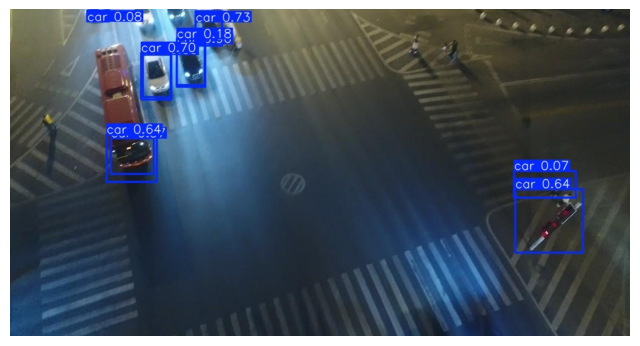

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/2209/low_alt_object_detection/training_logs/yolov8_low_alt/weights/best.pt")

results = model("/content/runs/detect/predict5/M0203_img000007.jpg", save=True, conf=0.01, verbose=True)

output_image_path = "runs/detect/predict7/M0203_img000007.jpg"

img = cv2.imread(output_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()